In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pyXRD import pyXRDCodes
from scipy.signal import find_peaks
from scipy.optimize import minimize
from matplotlib.gridspec import GridSpec
from typing import List, Tuple, Optional

In [3]:
class Cell:

    def __init__(self, 
                 unit_params: List[float], 
                 unit_angles: List[float], 
                 lamb: float, 
                 structure: str = 'orthorhombic',
                 param_step: float = 0.01,
                 angle_step: float = 0.1,
                 bounds_param: List[float] = [1, 20],
                 bounds_angle: List[float] = [50, 125],
                 structures: List[str] = ['cubic', 'hexagonal', 'tetragonal', 
                                         'orthorhombic', 'monoclinic', 'trigonal', 'triclinic']):
        """
        Initialize a unit cell with given parameters and constraints.
        
        Args:
            unit_params: List of lattice parameters [a, b, c] (should be nummpy array)
            unit_angles: List of lattice angles [α, β, γ] in degrees (should be nummpy array)
            lamb: Wavelength for diffraction calculations
            structure: Crystal system (must be in structures list)
            param_step: Step size for lattice parameter mutations
            angle_step: Step size for angle mutations
            bounds_param: [min, max] bounds for lattice parameters
            bounds_angle: [min, max] bounds for angles
            structures: List of allowed crystal systems
        """
        # Validate inputs
        if len(unit_params) != 3 or len(unit_angles) != 3:
            raise ValueError("Both unit_params and unit_angles must have length 3")
            
        if structure not in structures:
            raise ValueError(f"Structure must be one of: {structures}")
            
        if bounds_param[0] >= bounds_param[1] or bounds_angle[0] >= bounds_angle[1]:
            raise ValueError("Bounds must be in format [min, max] with min < max")
            
        # Initialize grids and validate parameters
        self.param_grid = np.arange(bounds_param[0], bounds_param[1], param_step)
        self.angle_grid = np.arange(bounds_angle[0], bounds_angle[1], angle_step)
        
        # Initialize properties
        self.unit_params = np.clip(np.array(unit_params, dtype=float), 
                                  bounds_param[0], bounds_param[1])
        self.unit_angles = np.clip(np.array(unit_angles, dtype=float), 
                                bounds_angle[0], bounds_angle[1])
        self.lamb = float(lamb)
        self.structure = structure
        self.structures = structures
        self.param_step = float(param_step)
        self.angle_step = float(angle_step)
        self.bounds_param = bounds_param
        self.bounds_angle = bounds_angle
        
        # Enforce structure constraints
        self._enforce_structure_constraints()
        self._validate_parameters()

    def _validate_parameters(self) -> None:
        """
        Ensure all parameters are within bounds
        """
        # Clip values to bounds
        self.unit_params = np.clip(self.unit_params, 
                                  self.bounds_param[0], self.bounds_param[1])
        self.unit_angles = np.clip(self.unit_angles, 
                                  self.bounds_angle[0], self.bounds_angle[1])
        
        # Round to nearest grid point
        for i in range(3):
            idx = np.abs(self.param_grid - self.unit_params[i]).argmin()
            self.unit_params[i] = self.param_grid[idx]
            
            idx = np.abs(self.angle_grid - self.unit_angles[i]).argmin()
            self.unit_angles[i] = self.angle_grid[idx]

    def _enforce_structure_constraints(self) -> None:
        """
        Enforce constraints based on crystal system, trying to find mean value for 
        parameter to make the cell according to its structure
        """
        # First clip all values to their grids
        self._validate_parameters()
        
        # Structure-specific constraints
        if self.structure == 'cubic':
            avg = np.round(np.mean(self.unit_params[:3]), 3)
            self.unit_params = np.array([avg]*3)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'tetragonal':
            avg_ab = np.round(np.mean(self.unit_params[:2]), 3)
            self.unit_params[0] = avg_ab
            self.unit_params[1] = avg_ab
            if abs(self.unit_params[2] - avg_ab) < 2*self.param_step:
                valid = self.param_grid[abs(self.param_grid - avg_ab) > 2*self.param_step]
                if len(valid) > 0:
                    self.unit_params[2] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'orthorhombic':
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 90], dtype=float)
            
        elif self.structure == 'monoclinic':
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            
            # Ensure β angle is not 90° and different from others
            if abs(self.unit_angles[1] - 90) < self.angle_step:
                valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                if len(valid) > 0:
                    self.unit_angles[1] = np.random.choice(valid)
            self.unit_angles[0] = 90
            self.unit_angles[2] = 90
            
        elif self.structure == 'hexagonal':
            avg_ab = np.round(np.mean(self.unit_params[:2]), 3)
            self.unit_params[0] = avg_ab
            self.unit_params[1] = avg_ab
            if abs(self.unit_params[2] - avg_ab) < 2*self.param_step:
                valid = self.param_grid[abs(self.param_grid - avg_ab) > 2*self.param_step]
                if len(valid) > 0:
                    self.unit_params[2] = np.random.choice(valid)
            self.unit_angles = np.array([90, 90, 120], dtype=float)
            
        elif self.structure == 'trigonal':
            avg = np.round(np.mean(self.unit_params[:3]), 1)
            self.unit_params = np.array([avg]*3)
            
            # For angles, either all 90° or all equal non-90°
            if all(abs(a - 90) < self.angle_step for a in self.unit_angles):
                # Change to non-90° angles
                valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                if len(valid) > 0:
                    angle = np.random.choice(valid)
                    self.unit_angles = np.array([angle]*3)
            else:
                # Make all angles equal
                avg_angle = np.round(np.mean(self.unit_angles), 3)
                self.unit_angles = np.array([avg_angle]*3)
                
        elif self.structure == 'triclinic':
            # Ensure all parameters and angles are different
            for i, j in [(0,1), (0,2), (1,2)]:
                if abs(self.unit_params[i] - self.unit_params[j]) < self.param_step:
                    valid = self.param_grid[abs(self.param_grid - self.unit_params[i]) > self.param_step]
                    if len(valid) > 0:
                        self.unit_params[j] = np.random.choice(valid)
            
            # Ensure angles are different and not 90°
            for i in range(3):
                if abs(self.unit_angles[i] - 90) < self.angle_step:
                    valid = self.angle_grid[abs(self.angle_grid - 90) > self.angle_step]
                    if len(valid) > 0:
                        self.unit_angles[i] = np.random.choice(valid)
            
            # Ensure all angles are different
            if len(set(np.round(self.unit_angles/self.angle_step))) < 3:
                angles = []
                available = list(self.angle_grid[abs(self.angle_grid - 90) > self.angle_step])
                for i in range(3):
                    if available:
                        angle = np.random.choice(available)
                        angles.append(angle)
                        available.remove(angle)
                    else:
                        angles.append(90 + (i+1)*10)  # Fallback
                self.unit_angles = np.array(angles)
        
        # Final validation
        self._validate_parameters()

    def give_theta2(self) -> np.ndarray:
        """
        Calculate 2θ angles for peaks giving the current cell, which is rounded to 0.01
        """
        _, _, calculated_theta, _ = pyXRDCodes.generate_hkls(
            self.lamb, 10, self.unit_params, self.unit_angles
        )
        return np.round(2*np.array(calculated_theta), 2) if len(calculated_theta) > 0 else np.array([])

    def mutate(self, 
              change_prob: float = 0.5,
              struct_change_prob: float = 0.05,
              change_shuffle:float =0.05,
              min_step_param: int = 1,
              max_step_param: int = 40,
              min_step_angle: int = 1,
              max_step_angle: int = 50) -> None:
        """Mutation with parameter and structure changes.
        
        Args:
            change_prob: Probability of changing a parameter
            min_step_param: Minimum mutation steps for parameters
            max_step_param: Maximum mutation steps for parameters
            min_step_angle: Minimum mutation steps for angles
            max_step_angle: Maximum mutation steps for angles
            struct_change_prob: Probability of changing crystal structure
        """
        # Parameter mutations
        for i in range(3):
            if random.random() < change_prob:
                # Define the number of steps this parameter is gonna take
                step = np.random.choice([-1, 1]) * np.random.randint(min_step_param, max_step_param)
                # Based on the number of steps take find the position on the grid
                idx = np.where(np.isclose(self.param_grid, self.unit_params[i]))[0][0]
                new_idx = max(0, min(len(self.param_grid)-1, idx + step))
                # Substitute the value as the value found in the grid
                self.unit_params[i] = self.param_grid[new_idx]
                
            # The same as before but for the angles
            if random.random() < change_prob:
                step = np.random.choice([-1, 1]) * np.random.randint(min_step_angle, max_step_angle)
                idx = np.where(np.isclose(self.angle_grid, self.unit_angles[i]))[0][0]
                new_idx = max(0, min(len(self.angle_grid)-1, idx + step))
                self.unit_angles[i] = self.angle_grid[new_idx]
        
        # Structure mutation 
        # ( I don't know If this  only mess things up - it can change the hole cell parameters )
        if random.random() < struct_change_prob and len(self.structures) > 1:
            self.structure = random.choice([s for s in self.structures if s != self.structure])
        
        # Shuffle the parameters
        # ( This was created so that  we could go from one place in the variable space to a very different)
        if random.random() <change_shuffle:
            self.unit_angles = random.sample(list(self.unit_angles),3)
            self.unit_params = random.sample(list(self.unit_params),3)
        
        # Enforce constraints
        self._enforce_structure_constraints()

    def crossover(self, other, inherit_prob: float = 0.7) -> 'Cell':
        """
        Blend two cells to create a new child cell
        """
        child = self.copy()
        
        for i in range(3):
            #if random.random() > inherit_prob:
            #    child.unit_params[i] = other.unit_params[i]
            #if random.random() > inherit_prob:
            #    child.unit_angles[i] = other.unit_angles[i]
            child.unit_params[i] = other.unit_params[i]*(1-inherit_prob) + inherit_prob*child.unit_params[i]
            child.unit_angles[i] = other.unit_angles[i]*(1-inherit_prob) + inherit_prob*child.unit_angles[i]


        if random.random() > inherit_prob:
            child.structure = other.structure
        
        child._enforce_structure_constraints()
        return child

    def copy(self) -> 'Cell':
        """Create a deep copy of the cell"""
        return Cell(
            self.unit_params.copy(), 
            self.unit_angles.copy(), 
            self.lamb, 
            self.structure,
            self.param_step,
            self.angle_step,
            self.bounds_param,
            self.bounds_angle,
            self.structures.copy()
        )

    def print_(self) -> str:
        """
        Function  to print the characteristics of the  cell
        """
        print(f"Cell(a={self.unit_params[0]:.2f}, b={self.unit_params[1]:.2f}, c={self.unit_params[2]:.2f}, "
               f"α={self.unit_angles[0]:.1f}°, β={self.unit_angles[1]:.1f}°, γ={self.unit_angles[2]:.1f}°, "
               f"structure='{self.structure}')")

In [4]:
def generate_initial_cell(
    structures: List[str],
    param_step: float = 0.01,
    angle_step: float = 0.1,
    param_bounds: List[float] = [1, 20],
    angle_bounds: List[float] = [50, 121],
    min_param_diff: float = 0.5,
    min_angle_diff: float = 5.0
) -> Tuple[List[float], List[float], str]:
    """
    Generate a random unit cell configuration according to crystal system constraints.
    
    Args:
        structures: List of allowed crystal systems
        params_list: Array of possible lattice parameter values
        angles_list: Array of possible angle values
        param_bounds: [min, max] bounds for lattice parameters
        angle_bounds: [min, max] bounds for angles
        min_param_diff: Minimum difference between distinct parameters
        min_angle_diff: Minimum difference between distinct angles
        
    Returns:
        Tuple of (unit_params, unit_angles, structure)
    """
    # Generate Grid with all possible values for each param giving bounds
    params_list = np.arange(param_bounds[0],param_bounds[1]+param_step,param_step)
    angles_list = np.arange(angle_bounds[0],angle_bounds[1]+angle_step,angle_step)

    # Validate inputs
    if len(param_bounds) != 2 or len(angle_bounds) != 2:
        raise ValueError("Bounds must be lists of length 2")
    if param_bounds[0] >= param_bounds[1] or angle_bounds[0] >= angle_bounds[1]:
        raise ValueError("Bounds must be in format [min, max] with min < max")
    
    # Select random crystal structure
    structure = random.choice(structures)
    
    # Helper function to get distinct parameters
    def get_distinct_param(exclude: List[float] = []) -> float:
        """Get a parameter value distinct from excluded values"""
        valid = params_list
        for val in exclude:
            valid = valid[np.abs(valid - val) >= min_param_diff]
        if len(valid) == 0:
            # Fallback: use any parameter if no distinct ones available
            return random.choice(params_list)
        return random.choice(valid)
    
    # Helper function to get distinct angles
    def get_distinct_angle(exclude: List[float] = [], not_90: bool = False) -> float:
        """Get an angle value distinct from excluded values"""
        valid = angles_list
        if not_90:
            valid = valid[np.abs(valid - 90) >= min_angle_diff]
        for val in exclude:
            valid = valid[np.abs(valid - val) >= min_angle_diff]
        if len(valid) == 0:
            # Fallback: use any angle if no distinct ones available
            return random.choice(angles_list)
        return random.choice(valid)
    
    # Generate parameters based on crystal system
    if structure == 'cubic':
        a = random.choice(params_list)
        b, c = a, a
        alpha, beta, gamma = 90.0, 90.0, 90.0
        
    elif structure == 'tetragonal':
        a = random.choice(params_list)
        b = a
        c = get_distinct_param([a])
        alpha, beta, gamma = 90.0, 90.0, 90.0
        
    elif structure == 'hexagonal':
        a = random.choice(params_list)
        b = a
        c = get_distinct_param([a])
        alpha, beta = 90.0, 90.0
        gamma = 120.0
        
    elif structure == 'orthorhombic':
        a = random.choice(params_list)
        b = get_distinct_param([a])
        c = get_distinct_param([a, b])
        alpha, beta, gamma = 90.0, 90.0, 90.0
        
    elif structure == 'monoclinic':
        a = random.choice(params_list)
        b = get_distinct_param([a])
        c = get_distinct_param([a, b])
        alpha, gamma = 90.0, 90.0
        beta = get_distinct_angle(not_90=True)
        
    elif structure == 'trigonal':
        a = random.choice(params_list)
        b, c = a, a
        angle = get_distinct_angle(not_90=True)
        alpha, beta, gamma = angle, angle, angle
        
    elif structure == 'triclinic':
        a = random.choice(params_list)
        b = get_distinct_param([a])
        c = get_distinct_param([a, b])
        alpha = get_distinct_angle(not_90=True)
        beta = get_distinct_angle(exclude=[alpha], not_90=True)
        gamma = get_distinct_angle(exclude=[alpha, beta], not_90=True)
        
    else:
        raise ValueError(f"Unknown crystal structure: {structure}")
    
    # Round values appropriately
    unit_params = [round(a, 2), round(b, 2), round(c, 2)]
    unit_angles = [round(alpha, 1), round(beta, 1), round(gamma, 1)]
    
    return unit_params, unit_angles, structure

In [5]:
def Vol_calc(unit_params,unit_angles,V_max):
    """
    Function that calculate the volume of the cell
    (Made so that I can know if giving the volume a cell is possible or not)
    """
    a = pyXRDCodes.abcToxyz([1,0,0],unit_params,unit_angles)
    b = pyXRDCodes.abcToxyz([0,1,0],unit_params,unit_angles)
    c = pyXRDCodes.abcToxyz([0,0,1],unit_params,unit_angles)

    V = abs(np.dot(a,np.cross(b,c)))
    if V>=V_max:
        return False
    return True

In [6]:
def diversity(cell,other_cell):
    """
    Calculate the distance in 6D space between variables
    From one Cell and the Best Cell
    """
    abc = (cell.unit_params - other_cell.unit_params)
    dot_abc = np.dot(abc,abc)
    abg = (cell.unit_angles - other_cell.unit_angles)
    dot_abg = np.dot(abg,abg)
    return np.sqrt(dot_abc + dot_abg) / np.sqrt( np.dot(cell.unit_params,cell.unit_params) *  np.dot(other_cell.unit_params,other_cell.unit_params)  )

In [51]:
# Put intensity

def cosine_fitness(cell, theta2_exp,int_exp, power=1, peak_tol=0.02,v_max=2500):
    """
    Cosine similarity-based fitness with power scaling for peak matching
    
    Args:
        struct: Candidate structure
        theta2_exp: Experimental 2θ peaks (degrees)
        int_exp: Experimental intensities for each 2θ peaks
        int_exp: Experimental intensities
        lamb: Wavelength (Å)
        alltheta2: All possible theoretical 2θ angles
        power: Exponent for cosine similarity (higher = stricter)
        peak_tol: Peak matching tolerance (degrees)
        
    Returns:
        -Fitness score (lower is better)
    """
    if not(Vol_calc(cell.unit_params,cell.unit_angles,v_max)):
        return 1e3
    # Calculate theoretical pattern
    alltheta2 = np.arange(min(theta2_exp)-2 , max(theta2_exp)+2,peak_tol)

    thetas2 = np.array(cell.give_theta2())
    mask = (thetas2>=min(alltheta2))&(thetas2<=max(alltheta2))
    thetas2 = thetas2[mask]

    # Initialize vectors
    v = np.zeros(len(alltheta2))             # experimental weighted vector
    u = np.zeros(len(alltheta2))  # theoretical vector default small penalty

    # Fill experimental intensities
    for t_exp, inten in zip(theta2_exp, int_exp):
        idx = np.argmin(np.abs(alltheta2 - t_exp))
        if np.abs(alltheta2[idx] - t_exp) <= peak_tol:
            v[idx] = inten

    # Fill theoretical peaks
    for t_theo in thetas2:
        idx = np.argmin(np.abs(alltheta2 - t_theo))
        # If experimental peak is at the same position, copy its intensity
        if v[idx] > 0:
            u[idx] = v[idx]
        else:
            u[idx] = 5.0  # default intensity for unmatched theoretical peak

    # Cosine similarity
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)

    if norm_u == 0 or norm_v == 0:
        return 1e3

    cosine_sim = dot_product / (norm_u * norm_v)
    fitness = (cosine_sim) ** power

    return -fitness  # lower is better






Fazer GA

In [ ]:
def remove_duplicates(population, abctol=1e-3,abgtol = 1e-1):
    unique_pop = []
    for cell in population:
        is_duplicate = False
        for ucell in unique_pop:
            # compara parâmetros de célula com tolerância
            if (np.allclose(cell.unit_params, ucell.unit_params, atol=abctol) and
                np.allclose(cell.unit_angles, ucell.unit_angles, atol=abgtol) and
                cell.structure == ucell.structure):
                is_duplicate = True
                break
        if not is_duplicate:
            unique_pop.append(cell)
    return unique_pop


def run_ga_List(observed_peaks,U_peaks,peak_tol=0.01,power=1, lamb=1.5406,
                generations=10, numb_pop=60,v_max = 1000,
                bounds_params = [1,25], bounds_angles = [50,125],param_step = 0.01,angle_step = 0.1,
                structure=['cubic','hexagonal','tetragonal','orthorhombic','monoclinic','trigonal','triclinic'],
                change_prob=0.1,change_shuffle=0.1, elit_frac=0.2, early_stag=3, inherit_prob=0.7):

    # Initialize population
    population = []

    # LATER ADD POSSIBILITY TO RECEIVE SOME GUESSES

    for i in range(len(structure)):
        for _ in range(numb_pop):
            abc, angles,struct = generate_initial_cell(structures=[structure[i],structure[i]],param_step=param_step,angle_step=angle_step,param_bounds=bounds_params,
                                                    angle_bounds=bounds_angles )
            population.append(Cell(abc, angles, lamb,struct,param_step,angle_step,bounds_params,bounds_angles,structure ))
    
    List_Best_Cells = []
    List_Best_Fitness = []

    best_cell = None
    best_fitness = float('inf')

    stagnation_count = 0
    Cells_history = [] # To look at the cells in each generation
    Fitness_history = [] # The Fintess in each generation


    # Loop for Generations
    for gen in range(generations):

        # Evaluate fitness
        fitness = [cosine_fitness(s,observed_peaks,int_exp = U_peaks,power=power,peak_tol=peak_tol,v_max = v_max) for s in population]

        Fitness_history.append(fitness)
        Cells_history.append(population)
        current_best = min(fitness)

        # Update best solution
        if current_best < best_fitness:
            best_fitness = current_best
            best_cell = population[np.argmin(fitness)]
            stagnation_count = 0

            # Add this to the resulting cells List
            List_Best_Cells.append(best_cell)
            List_Best_Fitness.append(current_best)
        else:
            stagnation_count += 1

        # ========== Reporting ==========
        print(f"Gen {gen+1}: Best Fitness = {best_fitness:.4f} \n"
              f"Params = {best_cell.unit_params if best_cell else None} | "
              f"Angles = {best_cell.unit_angles if best_cell else None}| Structure = {best_cell.structure}") 
        #================================================================
        # Re-did early stag
        if stagnation_count >= early_stag:
            stats = sorted(zip(population, fitness), key=lambda x: x[1])[1:] # Take out the best individual
            population = []
            population.extend([x[0] for x in stats])
            fitness = []
            fitness.extend([x[1] for x in stats])
            best_cell = None
            best_fitness = float('inf')

            stagnation_count = 0
        #================================================================
        best_cell_temp = population[np.argmin(fitness)]

        # ========== Selection ==========
        parents = []
        for _ in range(len(population)):
            # Select 3 Cells to serve as parents
            candidates = random.sample(range(len(population)), 3)
            # From the candidates find the best diversity individual and highest fit
            winner = candidates[np.argmin([fitness[c] - diversity(population[c],best_cell_temp) for c in candidates])] #if random.random() < 0.5 else random.choice(candidates)
            parents.append(population[winner])
        # ========== New generation ==========
        new_pop = []
        elite_size = int(elit_frac * numb_pop)
        elites = sorted(zip(population, fitness), key=lambda x: x[1])[:elite_size]
        for x in elites:
            c = x[0]
            c.mutate(change_prob = change_prob)
            new_pop.append(c)

        #new_pop.extend([x[0].mutate(change_prob=change_prob,change_shuffle=change_shuffle,struct_change_prob = 0) for x in elites])




        while len(new_pop) < numb_pop*len(structure):
            parent1, parent2 = np.random.choice(parents, 2)
            child = parent1.crossover(parent2, inherit_prob)
            current_change_prob = min(0.5, change_prob * (1 + stagnation_count / early_stag))
            child.mutate(change_prob=current_change_prob,change_shuffle=change_shuffle,struct_change_prob = 0)
            new_pop.append(child)

        population = new_pop
        
        
#=====================================================================
    # Evaluate fitness
    fitness = [cosine_fitness(s,observed_peaks,int_exp = U_peaks,power=power,peak_tol=peak_tol,v_max = v_max) for s in population]
    current_best = min(fitness)

    Fitness_history.append(fitness)
    Cells_history.append(population)
    
    # Update best solution
    if current_best < best_fitness:
        best_fitness = current_best
        best_cell = population[np.argmin(fitness)]

        # Add this to the resulting cells List
        List_Best_Cells.append(best_cell)
        List_Best_Fitness.append(current_best)


    # Put the list of possible cells in increasing order
    stats = sorted(zip(List_Best_Cells, List_Best_Fitness), key=lambda x: x[1])[1:] # Take out the best individual
    List_Best_Cells = []
    List_Best_Cells.extend([x[0] for x in stats])
    List_Best_Fitness = []
    List_Best_Fitness.extend([x[1] for x in stats])

    #================
    #ADD CODE TO TAKE OUT DUPLICATES IN THE 'List_Best_Cells'

    #================
    return best_cell,List_Best_Cells ,List_Best_Fitness , Cells_history,Fitness_history


In [53]:
# Define one Structure and plot the XRD data just so that I can see what I am doing
structure = 'cubic'

#Wavelenght used
lamb = 1.54
#Max order of the h,k,l indices
max_order = 10

#Get hole thing from CIF
targe_unit_params,targe_unit_angles , Pos_atoms , syme , target_Atoms = pyXRDCodes.INFOS_COD(f'CIFs_Used/Fe3O4_COD_1010369.cif')
target_Positions,pos_unit,pos_tot = pyXRDCodes.find_atoms_unit_cell(Pos_atoms,targe_unit_params,targe_unit_angles,syme,units=[3,3,3],hex = False)
data = pyXRDCodes.simulate_xrd(lamb,max_order,targe_unit_params,targe_unit_angles,target_Positions,target_Atoms)
theta2MX = data['two_thetas']
IbMX = data['intensities']
ZMX = data['Zs']

Lowest = -0.9845829665709861


(16.306341396560562, 64.60207209727491)

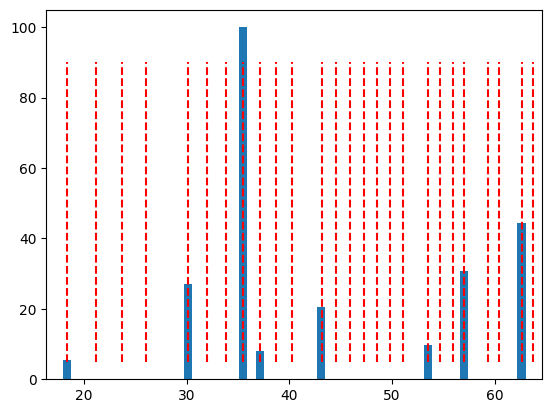

In [54]:
# Redefine the list
U = IbMX[(theta2MX>15) & (theta2MX<70)]
observed_theta =  theta2MX[(theta2MX>15) & (theta2MX<70)]

plt.bar(observed_theta,U)

# Now Run Simulations
real = Cell(targe_unit_params,targe_unit_angles,lamb,structure)
true_fit = (cosine_fitness(real, observed_theta,U, power=1, peak_tol=0.1,v_max=900))
print(f'Lowest = {true_fit}')

theta2 = real.give_theta2()
for i in range(len(theta2)):
    plt.plot(theta2[i]*np.ones(10) , np.linspace(5,90,10),'--',color='red')
plt.xlim(min(observed_theta)-2,max(observed_theta)+2)

In [55]:
# Run GA
structures=['cubic','orthorhombic','monoclinic','trigonal','tetragonal','triclinic','hexagonal']
best_cell,List_Best_Cells ,List_Best_Fitness , Cells_history,Fitness_history = run_ga_List(
                        observed_theta,
                        U,
                        peak_tol=0.1,
                        power=1,
                        v_max = 900,
                        lamb=lamb,
                        generations=25,
                        numb_pop= 40,
                        change_prob=0.6,
                        change_shuffle=0.2,
                        inherit_prob=0.6,
                        elit_frac=0.1,
                        early_stag=4,
                        bounds_params = [2,19], bounds_angles = [70,121],param_step = 0.01,angle_step = 0.1,
                        structure= structures, #'cubic'
                )


Gen 1: Best Fitness = -0.9002 
Params = [9.3 9.3 9.3] | Angles = [113.3 113.3 113.3]| Structure = trigonal
Gen 2: Best Fitness = -0.9002 
Params = [9.13 9.13 9.31] | Angles = [ 90.  90. 120.]| Structure = hexagonal
Gen 3: Best Fitness = -0.9046 
Params = [ 4.46  6.13 10.16] | Angles = [90. 90. 90.]| Structure = orthorhombic
Gen 4: Best Fitness = -0.9046 
Params = [ 4.79  6.13 10.16] | Angles = [90. 90. 90.]| Structure = orthorhombic
Gen 5: Best Fitness = -0.9046 
Params = [ 4.79  6.13 10.16] | Angles = [90. 90. 90.]| Structure = orthorhombic
Gen 6: Best Fitness = -0.9046 
Params = [ 4.79  6.13 10.16] | Angles = [90. 90. 90.]| Structure = orthorhombic
Gen 7: Best Fitness = -0.9046 
Params = [ 4.79  6.13 10.16] | Angles = [90. 90. 90.]| Structure = orthorhombic
Gen 8: Best Fitness = -0.9108 
Params = [9.1 9.1 9.1] | Angles = [97.9 97.9 97.9]| Structure = trigonal
Gen 9: Best Fitness = -0.9108 
Params = [9. 9. 9.] | Angles = [97.9 97.9 97.9]| Structure = trigonal
Gen 10: Best Fitness = -0

In [56]:
#Printar solução
real.print_()
print(f'True Fitness = {true_fit}')
print('=====')
for i in range(len(List_Best_Fitness)):
    c = List_Best_Cells[i]
    c.print_()
    print(f'|Fitness = {List_Best_Fitness[i]}')

Cell(a=8.38, b=8.38, c=8.38, α=90.0°, β=90.0°, γ=90.0°, structure='cubic')
True Fitness = -0.9845829665709861
=====
Cell(a=4.79, b=6.13, c=10.16, α=90.0°, β=90.0°, γ=90.0°, structure='orthorhombic')
|Fitness = -0.9045673924305442
Cell(a=9.13, b=9.13, c=9.31, α=90.0°, β=90.0°, γ=120.0°, structure='hexagonal')
|Fitness = -0.900184300055065
Cell(a=8.95, b=2.63, c=6.38, α=94.8°, β=97.2°, γ=92.0°, structure='triclinic')
|Fitness = -0.8827825309286352
Cell(a=8.85, b=8.08, c=6.36, α=108.5°, β=101.1°, γ=93.2°, structure='triclinic')
|Fitness = -0.8676494624332945
Cell(a=8.10, b=4.85, c=8.42, α=95.7°, β=98.2°, γ=101.0°, structure='triclinic')
|Fitness = -0.8583402756979319
Cell(a=8.61, b=7.22, c=7.37, α=102.1°, β=94.5°, γ=93.2°, structure='triclinic')
|Fitness = -0.8559851735116556


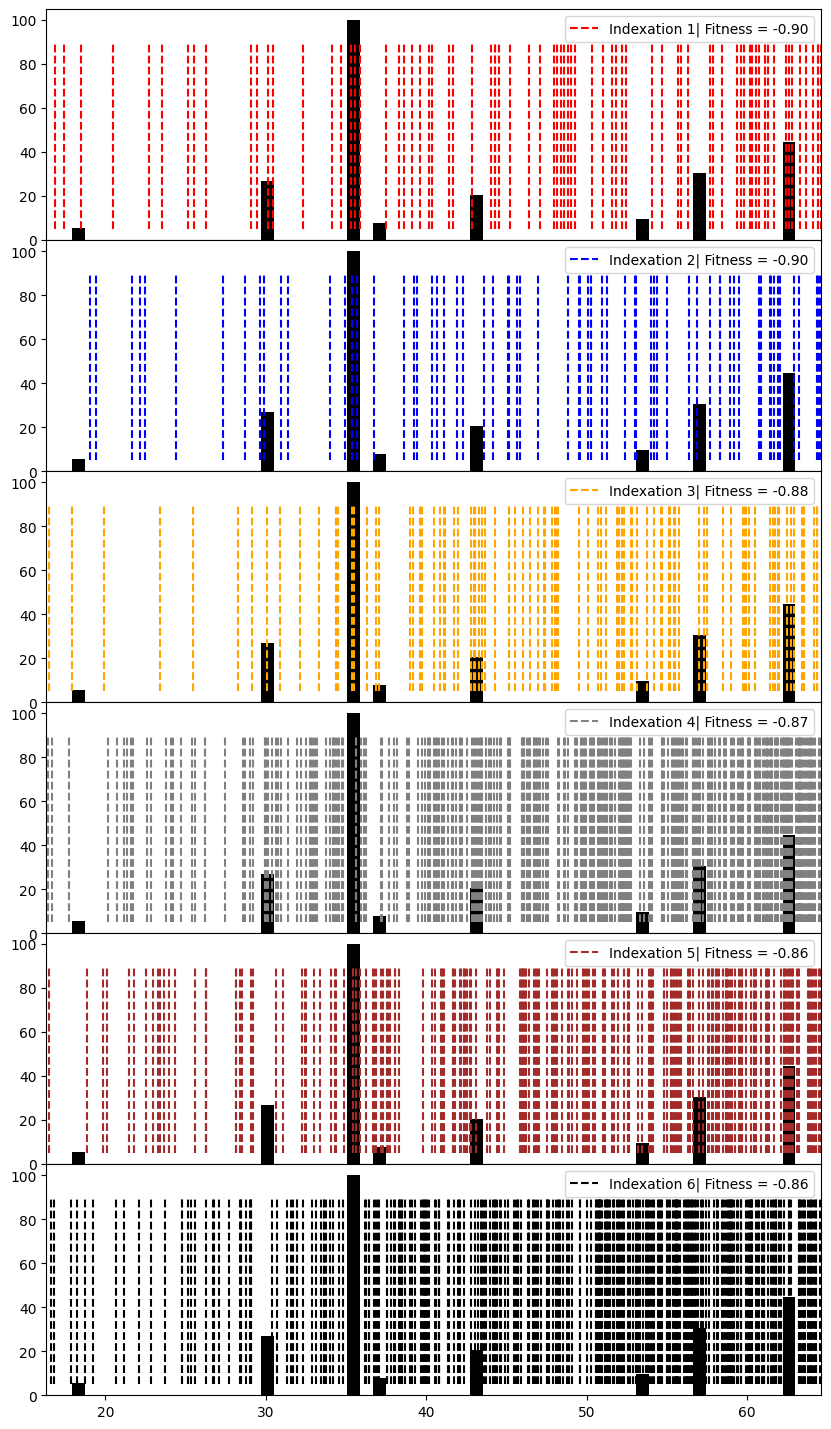

In [57]:

fig  = plt.figure(figsize = (10, len(List_Best_Fitness) * 3  ))
gs = GridSpec(len(List_Best_Fitness) , 1 , hspace = 0 )


color = 'red'
for i in range(len(List_Best_Fitness)):
    ax = fig.add_subplot(gs[i])

    ax.bar(observed_theta,U, color = 'black')

    c = List_Best_Cells[i]
    theta2 = c.give_theta2()

    ax.plot(theta2[0]*np.ones(10) , np.linspace(5,90,10),'--',color=colors[i],label = f'Indexation {i+1}| Fitness = {List_Best_Fitness[i]:.2f}')
    for j in range(1,len(theta2)):
        ax.plot(theta2[j]*np.ones(10) , np.linspace(5,90,10),'--',color=colors[i])

    ax.set_xlim(min(observed_theta)-2,max(observed_theta)+2)
    ax.legend()